<h1>Single model submission template.

<p>every model to be used must satisfy the APIs requirements of model_template.py, and must pass all the tests like test_model_template.py

In [6]:
"""
This is a template for the APIs of models to be used into the stacking framework.
run with Python 3.x
"""
from time import time, ctime
import lightgbm as lgb
import pandas as pd
import numpy as np
import pickle as pk
from matplotlib import pyplot as plt
from pathos.multiprocessing import ProcessingPool as Pool
from datetime import datetime, date
import shap
import sys
import os


def sigma_score(preds, valid_data):
    """
    this is a custom metric used to train the model_lgbm_baseline
    """
    df_time = valid_data.params['extra_time'] # will be injected afterwards
    labels = valid_data.get_label()
    
    #    assert len(labels) == len(df_time)

    x_t = preds * labels #  * df_valid['universe'] -> Here we take out the 'universe' term because we already keep only those equals to 1.
    
    # Here we take advantage of the fact that `labels` (used to calculate `x_t`)
    # is a pd.Series and call `group_by`
    x_t_sum = x_t.groupby(df_time).sum()
    score = x_t_sum.mean() / x_t_sum.std()

    return 'sigma_score', score, True

class model():
    """this is a baseline lightLGB model with simple features

    this class is for a model (that can also be
    a combination of bagged models)
    The commonality of the bagged models is that
    they share the feature generation
    """

    def __init__(self, name):
        self.name             = name
        self.type             = lgb.Booster
        self.model1 = None
        self.model2 = None
        self.model3 = None
        self.model4 = None
        self.model5 = None
        self.model6 = None
        self.training_results = None
        print("\ninit model {}".format(self.name))
        sys.path.insert(0, '../') # this is for imports from /kernels

    def _preprocess(self, market_data):
        """optional data preprocessing"""
        try:
            market_data = market_data.loc[market_data['time']>=date(2010, 1, 1)]
        except TypeError: # if 'time' is a string value
            print("[_generate_features] 'time' is of type str and not datetime")
            if not market_data.loc[market_data['time']>="2010"].empty:
                # if dates are before 2010 means dataset is for testing
                market_data = market_data.loc[market_data['time']>="2010"]
        assert market_data.empty == False
        return market_data
        

    def _generate_features(self, market_data, news_data, verbose=False, normalize=True):
        """
        GENERAL:
        given the original market_data and news_data
        generate new features, doesn't change original data.
        NOTE: data cleaning and preprocessing is not here,
        here is only feats engineering
        
        MODEL SPECIFIC:
        as as a baseline for decision trees model we add
        features that are the most popular among public
        kernels on Kaggle:
        
        - [36] short-term lagged features on returns
        - has been removed (cant pass tests) [6]  long-term moving averages
        - [1]  day of the week

        Args:
            [market_train_df, news_train_df]: pandas.DataFrame
            normalize: should be True, but for testing we need to
                 be able to toggle to check real values
        Returns:
            complete_features: pandas.DataFrame
        """
        #from utils import progress
        start_time = time()
        if verbose: print("Starting features generation for model {}, {}".format(self.name, ctime()))

        complete_features = market_data.copy()

        if 'returnsOpenNextMktres10' in complete_features.columns:
            complete_features.drop(['returnsOpenNextMktres10'],axis=1,inplace=True)

        #### [36] short-term lagged features on returns ####
          

        def create_lag(df_code,n_lag=[3,7,14,],shift_size=1):
            code = df_code['assetCode'].unique()
            
            # how to print progress in preprocessing?
            # progress(0, len(n_lag)*len(return_features), prefix = 'Lagged features generation:', length=50)
            # print("\rcreating lags for {}".format(code))
            for _feature, col in enumerate(return_features):
                for _lag, window in enumerate(n_lag):
                    rolled = df_code[col].shift(shift_size).rolling(window=window)
                    lag_mean = rolled.mean()
                    lag_max = rolled.max()
                    lag_min = rolled.min()
                    lag_std = rolled.std()
                    df_code['lag_%s_%s_mean'%(window,col)] = lag_mean
                    df_code['lag_%s_%s_max'%(window,col)] = lag_max
                    df_code['lag_%s_%s_min'%(window,col)] = lag_min
        #             df_code['%s_lag_%s_std'%(col,window)] = lag_std
                    #progress(_feature * len(n_lag) + _lag, len(n_lag) * len(return_features), 
                    #prefix = 'Lagged features generation:', length = 50)
            return df_code.fillna(-1)

        def generate_lag_features(df,n_lag = [3,7,14]):
            features = ['time', 'assetCode', 'assetName', 'volume', 'close', 'open',
               'returnsClosePrevRaw1', 'returnsOpenPrevRaw1',
               'returnsClosePrevMktres1', 'returnsOpenPrevMktres1',
               'returnsClosePrevRaw10', 'returnsOpenPrevRaw10',
               'returnsClosePrevMktres10', 'returnsOpenPrevMktres10',
               'returnsOpenNextMktres10', 'universe']
            
            assetCodes = df['assetCode'].unique()
            print(assetCodes)
            all_df = []
            df_codes = df.groupby('assetCode')
            df_codes = [df_code[1][['time','assetCode']+return_features] for df_code in df_codes]
            print('total %s df'%len(df_codes))

            pool = Pool(4)
            all_df = pool.map(create_lag, df_codes)
            
            new_df = pd.concat(all_df)  
            new_df.drop(return_features,axis=1,inplace=True)
            pool.close()

            # for the next two lines
            # https://stackoverflow.com/questions/49888485/pathos-multiprocessings-pool-appears-to-be-nonlocal
            pool.terminate()
            pool.restart()
            
            return new_df

        return_features = ['returnsClosePrevMktres10','returnsClosePrevRaw10','open','close']
        n_lag = [3,7,14]
        new_df = generate_lag_features(complete_features,n_lag=n_lag)
        new_df['time'] = pd.to_datetime(new_df['time'])
        complete_features['time'] = pd.to_datetime(complete_features['time'])
        complete_features = pd.merge(complete_features,new_df,how='left',on=['time','assetCode'])
        self.max_lag = max(n_lag)

        complete_features = self._clean_data(complete_features)

        #### [1]  generate labels encoding for assetCode ####

        def data_prep(market_train):
            """procedure from https://www.kaggle.com/guowenrui/sigma-eda-versionnew
            """
            lbl = {k: v for v, k in enumerate(market_train['assetCode'].unique())}
            market_train['assetCodeT'] = market_train['assetCode'].map(lbl)
            market_train = market_train.dropna(axis=0)
            return market_train

        complete_features = data_prep(complete_features)


        #### drop columns ####

        fcol = [c for c in complete_features if c not in ['assetCode', 'assetCodes', 'assetCodesLen', 'assetName', 'audiences', 
                                                         'firstCreated', 'headline', 'headlineTag', 'marketCommentary', 'provider', 
                                                                                                      'returnsOpenNextMktres10', 'sourceId', 'subjects', 'time', 'time_x', 'universe','sourceTimestamp']]
        complete_features = complete_features[fcol]


        #### normalization of input ####

        if normalize:
            mins = np.min(complete_features, axis=0)
            maxs = np.max(complete_features, axis=0)
            rng = maxs - mins
            complete_features = 1 - ((maxs - complete_features) / rng)

        if verbose: print("Finished features generation for model {}, TIME {}".format(self.name, time()-start_time))
        return complete_features

    def _generate_target(self, Y):
        """
        given Y generate binary labels
        returns:
            up, r : (binary labels), (returns)
        """
        binary_labels = Y >= 0
        return binary_labels.astype(int).values, Y.values

    def train(self, X, Y, verbose=False):
        """
        GENERAL:
        basic method to train a model with given data
        model will be inside self.model after training
        
        MODEL SPECIFIC:
        
        - sklearn random split
        - universe filter on validation
        - binary classification
            need to put 'metric':'None' in parameters
        - target is Y > 0 
        
        Args:
            X: [market_train_df, news_train_df]
            Y: [target]
            verbose: (bool)
        Returns:
            (optional) training_results
        """
        start_time = time()
        if verbose: print("Starting training for model {}, {}".format(self.name, ctime()))
            
        time_reference = X[0]['time'] #time is dropped in preprocessing, but is needed later for metrics eval
        universe_reference = X[0]['universe']

        X = self._generate_features(X[0], X[1], verbose=verbose)
        binary_Y, Y = self._generate_target(Y)

        try:
            assert X.shape[0] == binary_Y.shape[0] == Y.shape[0]
        except AssertionError:
            import pdb;pdb.set_trace()
            pass

        from sklearn import model_selection
        X_train, X_val,\
        binary_Y_train, binary_Y_val,\
        Y_train, Y_val,\
        universe_train, universe_val,\
        time_train, time_val = model_selection.train_test_split(
                X, 
                binary_Y,
                Y,
                universe_reference.values,
                time_reference, test_size=0.25, random_state=99)

        assert X_train.shape[0] == Y_train.shape[0] == binary_Y_train.shape[0]

        if verbose: print("X_train shape {}".format(X_train.shape))
        if verbose: print("X_val shape {}".format(X_val.shape))
        assert X_train.shape[0] != X_val.shape[0]
        assert X_train.shape[1] == X_val.shape[1]

        # train parameters prearation
        train_cols = X.columns.tolist()
        assert 'returnsOpenNextMktres10' not in train_cols 
        train_data = lgb.Dataset(X.values, binary_Y, feature_name=train_cols)
        test_data = lgb.Dataset(X_val.values, binary_Y_val, feature_name=train_cols)

        x_1 = [0.19000424246380565, 2452, 212, 328, 202]
        x_2 = [0.19016805202090095, 2583, 213, 312, 220]
        x_3 = [0.19564034613157152, 2452, 210, 160, 219]
        x_4 = [0.19016805202090095, 2500, 213, 150, 202]
        x_5 = [0.19000424246380565, 2600, 215, 140, 220]
        x_6 = [0.19000424246380565, 2652, 216, 152, 202]

        params_1 = {
                'task': 'train',
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'learning_rate': x_1[0],
                'num_leaves': x_1[1],
                'min_data_in_leaf': x_1[2],
                'num_iteration': 239,
                'max_bin': x_1[4],
                'verbose': 1
            }

        params_2 = {
                'task': 'train',
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'learning_rate': x_2[0],
                'num_leaves': x_2[1],
                'min_data_in_leaf': x_2[2],
                'num_iteration': 172,
                'max_bin': x_2[4],
                'verbose': 1
            }


        params_3 = {
                'task': 'train',
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'learning_rate': x_3[0],
                'num_leaves': x_3[1],
                'min_data_in_leaf': x_3[2],
                'num_iteration': x_3[3],
                'max_bin': x_3[4],
                'verbose': 1
            }

        params_4 = {
                'task': 'train',
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'learning_rate': x_4[0],
                'num_leaves': x_4[1],
                'min_data_in_leaf': x_4[2],
                'num_iteration': x_4[3],
                'max_bin': x_4[4],
                'verbose': 1
            }

        params_5 = {
                'task': 'train',
                'boosting_type': 'gbdt',#dart
                'objective': 'binary',
                'learning_rate': x_5[0],
                'num_leaves': x_5[1],
                'min_data_in_leaf': x_5[2],
                'num_iteration': x_5[3],
                'max_bin': x_5[4],
                'verbose': 1
            }

        params_6 = {
                'task': 'train',
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'learning_rate': x_6[0],
                'num_leaves': x_6[1],
                'min_data_in_leaf': x_6[2],
                'num_iteration': x_6[3],
                'max_bin': x_6[4],
                'verbose': 1
            }

        training_results = {}
        self.model1 = lgb.train(params_1,
                train_data,
                num_boost_round=100,
                valid_sets=(test_data, train_data),
                valid_names=('valid','train'),
                early_stopping_rounds=5,
                verbose_eval=1,
                evals_result=training_results)

        self.model2 = lgb.train(params_2,
                train_data,
                valid_sets=(test_data, train_data),
                valid_names=('valid','train'),
                num_boost_round=100,
                verbose_eval=1,
                early_stopping_rounds=5,
                evals_result=training_results)


        self.model3 = lgb.train(params_3,
                train_data,
                num_boost_round=100,
                valid_sets=test_data,
                early_stopping_rounds=5,
        #         fobj=exp_loss,
                )

        self.model4 = lgb.train(params_4,
                train_data,
                num_boost_round=100,
                valid_sets=test_data,
                early_stopping_rounds=5,
        #         fobj=exp_loss,
                )

        self.model5 = lgb.train(params_5,
                train_data,
                num_boost_round=100,
                valid_sets=test_data,
                early_stopping_rounds=5,
        #         fobj=exp_loss,
                )


        self.model6 = lgb.train(params_6,
                train_data,
                num_boost_round=100,
                valid_sets=test_data,
                early_stopping_rounds=10,
        #         fobj=exp_loss,
                )

        del X, X_train, X_val

        if verbose: print("Finished training for model {}, TIME {}".format(self.name, time()-start_time))

        self._save()
        self.training_results = training_results
        return training_results 

    def predict(self, X, verbose=False, do_shap=False):
        """
        given a block of X features gives prediction for everyrow

        Args:
            X: [market_train_df, news_train_df]
            shap: perform shap analysis
        Returns:
            y: pandas.Series
        """
        start_time = time()
        if verbose: print("Starting prediction for model {}, {}".format(self.name, ctime()))
        if self.model1 is None or self.model2 is None:
            raise "Error: model is not trained!"

        X_test = self._generate_features(X[0], X[1], verbose=verbose)
        if verbose: print("X_test shape {}".format(X_test.shape))
        preds= [self.model1.predict(X_test), self.model2.predict(X_test)]
        preds.append(self.model3.predict(X_test))
        preds.append(self.model4.predict(X_test))
        preds.append(self.model5.predict(X_test))
        preds.append(self.model6.predict(X_test))
        y_test = self._postprocess(preds)

        if do_shap:
            #import pdb;pdb.set_trace()
            print("printing shap analysis..")
            explainer = shap.TreeExplainer(self.model1)
            shap_values = explainer.shap_values(X_test)
            shap.summary_plot(shap_values, X_test)


        if verbose: print("Finished prediction for model {}, TIME {}".format(self.name, time()-start_time))
        return y_test

    def predict_rolling(self, historical_df, prediction_length, verbose=False):
        """
        predict features from X, uses historical for (lagged) feature generation
        to be used with rolling prediciton structure from competition

        Args:
            historical_df: [market_train_df, news_train_df]
            prediction_length: generate features on historical_df, predict only on the last rows
        """
        start_time = time()
        if verbose: print("Starting rolled prediction for model {}, {}".format(self.name, ctime()))
        if self.model1 is None or self.model2 is None:
            raise "Error: model is not trained!"

        processed_historical_df = self._generate_features(historical_df[0], historical_df[1], verbose=verbose)
        X_test = processed_historical_df.iloc[-prediction_length:]
        if verbose: print("X_test shape {}".format(X_test.shape))
        preds= [self.model1.predict(X_test), self.model2.predict(X_test)]
        preds.append(self.model3.predict(X_test))
        preds.append(self.model4.predict(X_test))
        preds.append(self.model5.predict(X_test))
        preds.append(self.model6.predict(X_test))
        y_test = self._postprocess(preds)

        if verbose: print("Finished rolled prediction for model {}, TIME {}".format(self.name, time()-start_time))
        return y_test

    def inspect(self, X):
        """
        visualize and examine the training of the model
        Args:
            X: for the shap values

        MODEL SPECIFIC:
        plots training results and feature importance
        """
        if not self.training_results:
            print("Error: No training results available")
        else:
            print("printing training results..")
            for _label, key in self.training_results.items():
                for label, result in key.items():
                    plt.plot(result,label=_label+" "+label)
            plt.title("Training results")
            plt.legend()
            plt.show()

        if not self.model1:
            print("Error: No model available")
        else:
            print("printing feature importance..")
            f=lgb.plot_importance(self.model1)
            f.figure.set_size_inches(10, 30) 
            plt.show()

    def _postprocess(self, predictions):
        """
        post processing of predictions

        Args:
            predictions: list(np.array) might be from
                different models
        Return:
            predictions: np.array

        MODEL SPECIFIC:
        the postprocessing is needed to ensemble bagged
        models and to map prediction interval from [0, 1] 
        to [-1, 1]
        """
        y_test = sum(predictions)/len(predictions)
        y_test = (y_test-y_test.min())/(y_test.max()-y_test.min())
        y_test = y_test * 2 - 1
        return y_test

    def _clean_data(self, data):
        """
        originally from function mis_impute in
        https://www.kaggle.com/guowenrui/sigma-eda-versionnew

        Args:
            data: pd.DataFrame
        returns:
            cleaned data (not in place)
        """
        for i in data.columns:
            if data[i].dtype == "object":
                    data[i] = data[i].fillna("other")
            elif (data[i].dtype == "int64" or data[i].dtype == "float64"):
                    data[i] = data[i].fillna(data[i].mean())
            else:
                    pass
        return data

    def _save(self):
        """
        save models to memory into pickle/self.name
        """
        to_save = [self.model1, self.model2, self.model3, self.model4, self.model5, self.model6]
        if not all(to_save):
            print("[_save] Error: not all models are trained")
            print(to_save)
        else:
            save_name = os.path.join("../pickle",self.name+"_")
            with open(save_name,"wb") as f:
                pk.dump(to_save, f)
                print("[_save] saved models to "+save_name)

    def _load(self):
        """
        load models to memory from pickle/self.name
        """
        save_name = os.path.join("../pickle",self.name)+".pkl"
        with open(save_name,"rb") as f:
            models = pk.load(f)
        self.model1 = models[0]
        self.model2 = models[1]
        self.model3 = models[2]
        self.model4 = models[3]
        self.model5 = models[4]
        self.model6 = models[5]
        print("[_load] models loaded succesfully")



<h1>Get data

In [ ]:
from kaggle.competitions import twosigmanews
# You can only call make_env() once, so don't lose it!
env = twosigmanews.make_env()

In [ ]:
(market_train_df, news_train_df) = env.get_training_data()

<h1>`Datacleaning and preprocessing procedure

datacleaning will applied to the whole dataset for every model, the only requirements is that at the end of the procedure ***NO NEW FEATURES can be added here***. They must be added inside the feature generation section of the model

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
market_train_df = market_train_df.loc[market_train_df['time'] >= '2010-01-01 22:00:00+0000']

<h1>Initialize and train model

In [ ]:
model = model('lgbm_71')

In [ ]:
target = market_train_df.returnsOpenNextMktres10
market_train_df.drop('returnsOpenNextMktres10', axis=1, inplace=True)

In [ ]:
model.train([market_train_df, news_train_df], target, verbose=True)

<h1>(or load pre-trained models)

In [10]:
PRETRAINED = True

In [11]:
if PRETRAINED:
    import sys;sys.path.append('../')
    import os
    os.listdir('../pickle')
    model = model('DecisionTree.model_lgbm_71')
    model._load()


init model DecisionTree.model_lgbm_71
[_load] models loaded succesfully


Error: No training results available
printing feature importance..


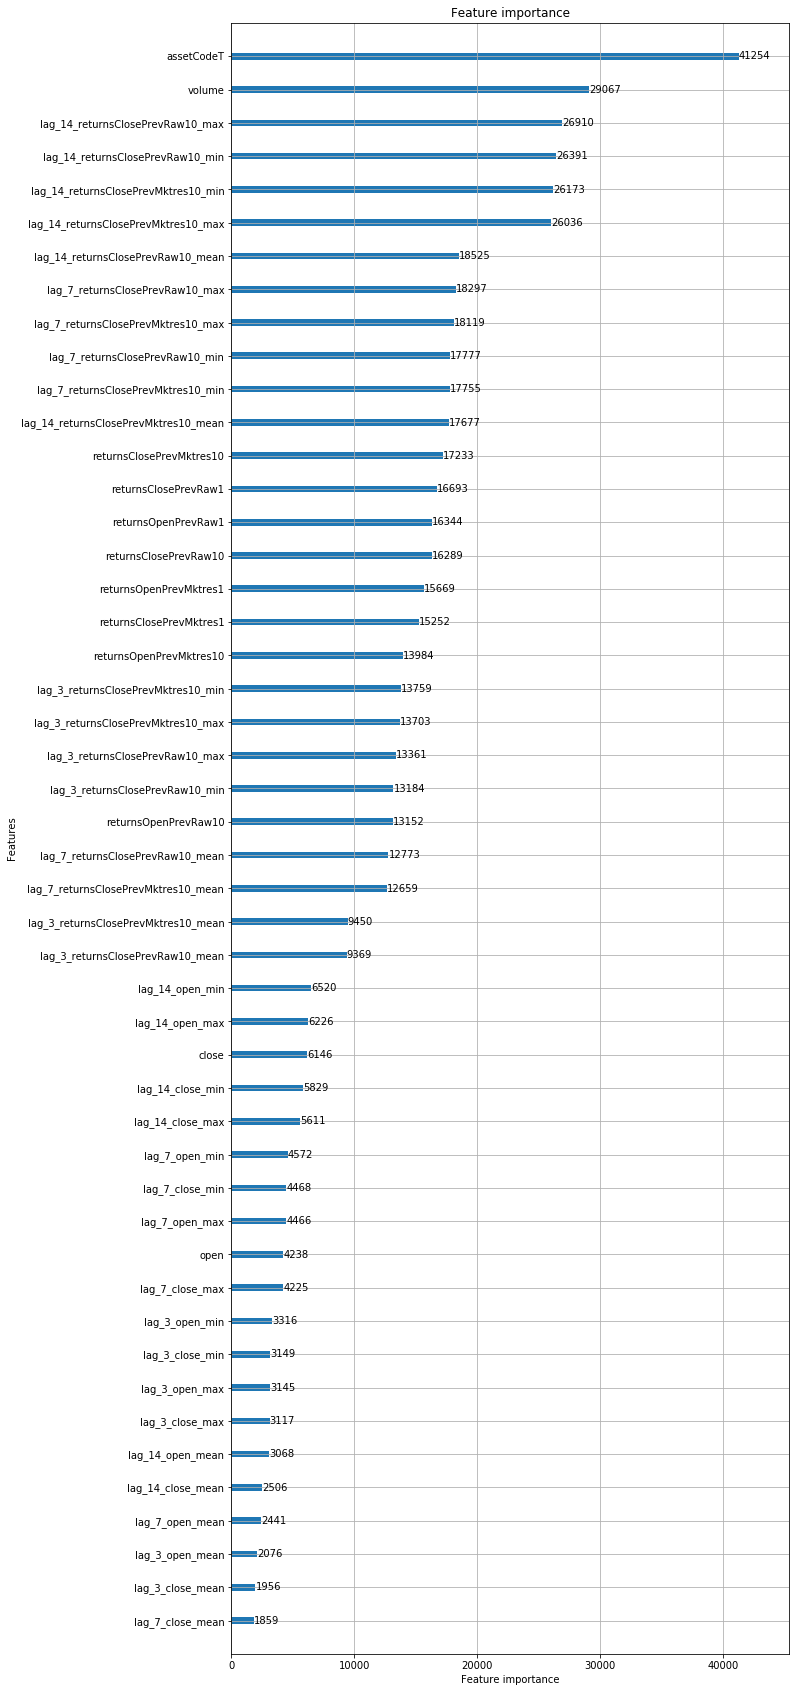

In [12]:
model.inspect(None)

<h1>Prediction loop

In [ ]:
days = env.get_prediction_days()

In [ ]:
# skip a prediction (for testing)
#env.predict(predictions_template_df)

In [ ]:
#prediction
days = env.get_prediction_days()
n_days = 0
prep_time = 0
prediction_time = 0
packaging_time = 0
total_market_obs_df = []
for (market_obs_df, news_obs_df, predictions_template_df) in days:
    n_days +=1
    if (n_days%50==0):
        pass
        #print(n_days,end=' ')
    t = time.time()
    market_obs_df['time'] = market_obs_df['time'].dt.date

    total_market_obs_df.append(market_obs_df)
    if len(total_market_obs_df)==1:
        history_df = total_market_obs_df[0]
    else:
        history_df = pd.concat(total_market_obs_df[-(np.max(n_lag)+1):])
        
    confidence = model.predict([history_df, None],verbose=True)      
        
    preds = pd.DataFrame({'assetCode':market_obs_df['assetCode'],'confidence':confidence})
    predictions_template_df = predictions_template_df.merge(preds,how='left').drop('confidenceValue',axis=1).fillna(0).rename(columns={'confidence':'confidenceValue'})
    env.predict(predictions_template_df)
    packaging_time += time.time() - t
    
env.write_submission_file()
sub  = pd.read_csv("submission_versionnew.csv")

In [ ]:
"""BEFORE DELETING OLD VERSION CHECK NEW VERSION IS WORKING
from time import time, ctime

total_market_df = pd.DataFrame(columns=['time', 'assetCode', 'assetName', 'volume', 'close', 'open',
       'returnsClosePrevRaw1', 'returnsOpenPrevRaw1',
       'returnsClosePrevMktres1', 'returnsOpenPrevMktres1',
       'returnsClosePrevRaw10', 'returnsOpenPrevRaw10',
       'returnsClosePrevMktres10', 'returnsOpenPrevMktres10','period', 'universe'])

max_lag, days_count = model.max_lag, 0
for (market_obs_df, news_obs_df, predictions_template_df) in days:
    days_count += 1
    if not days_count%50: print(days_count)
        
    market_obs_df['period']   = days_count
    market_obs_df['universe'] = 1
    
    start_time = time()
    total_market_df = pd.concat([total_market_df, market_obs_df])
    #total_news_obs_df.append(news_obs_df)
        
    history_market_df = total_market_df[total_market_df['period'] > days_count - max_lag - 1].drop('period', axis=1).reset_index(drop=True)
    confidence = model.predict_rolling([history_market_df, None],
                                        len(predictions_template_df), verbose=True)
    
    predictions_template_df.confidenceValue = confidence
    env.predict(predictions_template_df)
    print("[{}] loop prediction {}, TIME {}".format(days_count, ctime(), time()-start_time))
print('Done!')
"""

## **`write_submission_file`** function

Writes your predictions to a CSV file (`submission.csv`) in the current working directory.

In [ ]:
env.write_submission_file()

In [ ]:
# We've got a submission file!
import os
print([filename for filename in os.listdir('.') if '.csv' in filename])

As indicated by the helper message, calling `write_submission_file` on its own does **not** make a submission to the competition.  It merely tells the module to write the `submission.csv` file as part of the Kernel's output.  To make a submission to the competition, you'll have to **Commit** your Kernel and find the generated `submission.csv` file in that Kernel Version's Output tab (note this is _outside_ of the Kernel Editor), then click "Submit to Competition".  When we re-run your Kernel during Stage Two, we will run the Kernel Version (generated when you hit "Commit") linked to your chosen Submission.

## Restart the Kernel to run your code again
In order to combat cheating, you are only allowed to call `make_env` or iterate through `get_prediction_days` once per Kernel run.  However, while you're iterating on your model it's reasonable to try something out, change the model a bit, and try it again.  Unfortunately, if you try to simply re-run the code, or even refresh the browser page, you'll still be running on the same Kernel execution session you had been running before, and the `twosigmanews` module will still throw errors.  To get around this, you need to explicitly restart your Kernel execution session, which you can do by pressing the Restart button in the Kernel Editor's bottom Console tab:
![Restart button](https://i.imgur.com/hudu8jF.png)